In [1]:
# Import Python Packages
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug
import zipfile
import shutil
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
zip_ref = zipfile.ZipFile("/content/drive/My Drive/Mask_RCNN.zip", 'r')
zip_ref.extractall("/content/Mask_RCNN")
zip_ref.close()

In [3]:
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN/Mask_RCNN/")
sys.path.append(ROOT_DIR)  # To find local version of the library

In [4]:
os.listdir(ROOT_DIR)

['mrcnn',
 'samples',
 '.gitignore',
 'LICENSE',
 'README.md',
 'setup.py',
 'setup.cfg',
 'images',
 'data',
 'assets',
 'requirements.txt',
 'MANIFEST.in']

In [5]:
# Import Mobile Mask R-CNN Packages
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib
%matplotlib inline 

In [6]:
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [7]:

class KernelConfig(Config):
    NAME = "kernel_stained"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = 3  
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    STEPS_PER_EPOCH = 500

    VALIDATION_STEPS = 5
    
    BACKBONE = 'resnet50'

    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = KernelConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [11]:
class CocoLikeDataset(utils.Dataset):
    def load_data(self, annotation_json, images_dir):
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[str(image_id)]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [12]:
import json
import mrcnn.model as modellib

from PIL import Image,ImageDraw

In [13]:
dataset_train = CocoLikeDataset()
dataset_train.load_data(ROOT_DIR+'/data/coco/train/train_annotations.json',ROOT_DIR+ '/data/coco/train/images')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data(ROOT_DIR+'/data/coco/val/val_annotations.json', ROOT_DIR+'/data/coco/val/images')
dataset_val.prepare()

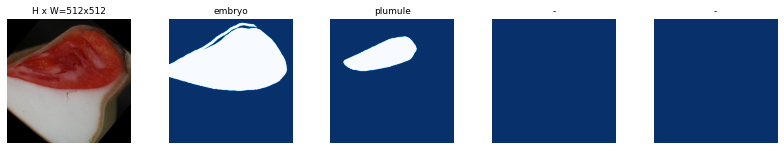

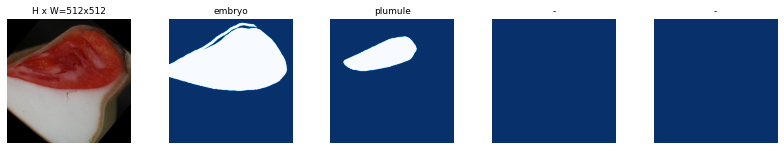

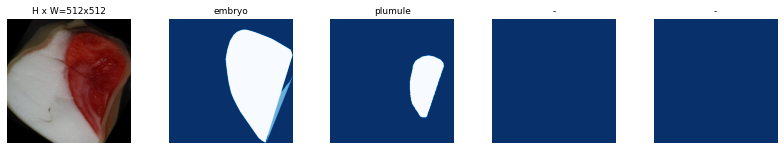

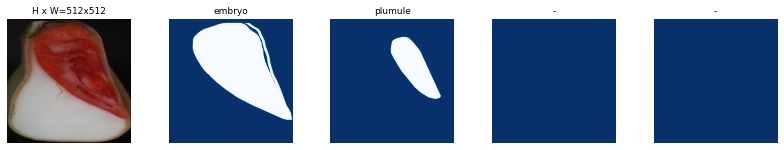

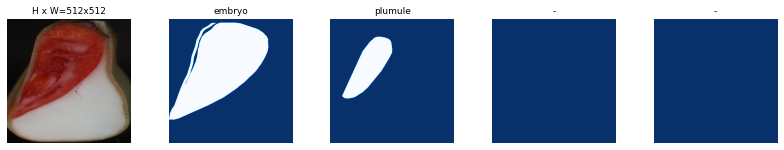

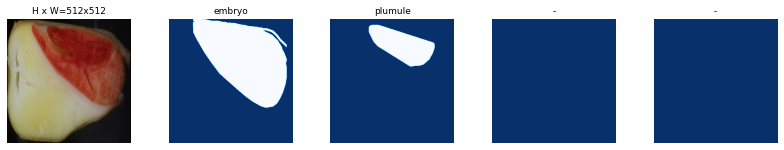

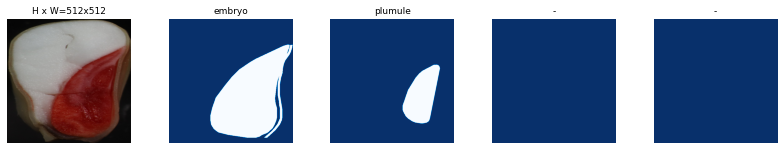

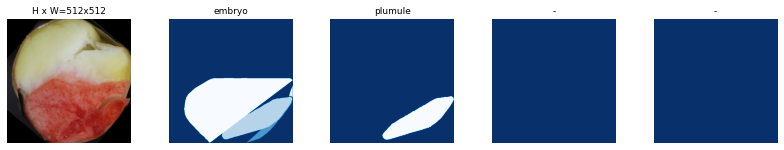

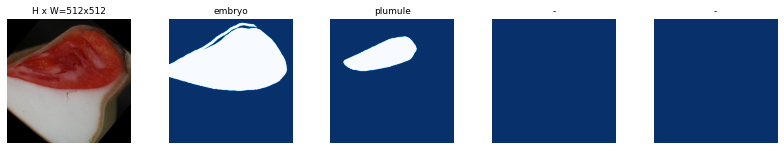

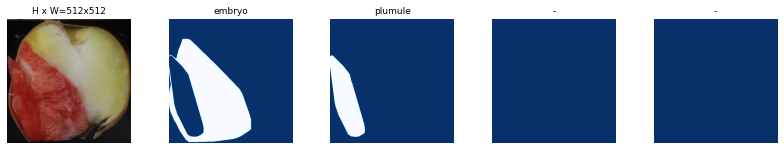

In [15]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 10)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [16]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [17]:
init_with = "coco"  
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model.load_weights(model.find_last(), by_name=True)

In [18]:
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/Mask_RCNN/logs/kernel_stained20210509T0539/mask_rcnn_kernel_stained_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_cl

500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 2.2161 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.3842 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.3055 - mrcnn_mask_loss: 0.2680

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


500/500 [==============================] - 141s 204ms/step - batch: 249.5000 - size: 1.0000 - loss: 2.2161 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 1.3842 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.3055 - mrcnn_mask_loss: 0.2680 - val_loss: 3.1051 - val_rpn_class_loss: 0.0258 - val_rpn_bbox_loss: 2.0282 - val_mrcnn_class_loss: 0.4652 - val_mrcnn_bbox_loss: 0.2614 - val_mrcnn_mask_loss: 0.3245
Epoch 2/5
500/500 [==============================] - 98s 195ms/step - batch: 249.5000 - size: 1.0000 - loss: 1.0992 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.6249 - mrcnn_class_loss: 0.1905 - mrcnn_bbox_loss: 0.1194 - mrcnn_mask_loss: 0.1558 - val_loss: 0.8374 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 0.4459 - val_mrcnn_class_loss: 0.1819 - val_mrcnn_bbox_loss: 0.1021 - val_mrcnn_mask_loss: 0.0985
Epoch 3/5
500/500 [==============================] - 96s 192ms/step - batch: 249.5000 - size: 1.0000 - loss: 0.7887 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.4420 - mrcnn_class_loss: 0.

In [19]:
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=10, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 5. LR=0.0001

Checkpoint Path: /content/Mask_RCNN/Mask_RCNN/logs/kernel_stained20210509T0539/mask_rcnn_kernel_stained_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training_2/SGD/gradients/gradients/ro

500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 0.9868 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.2569 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.0854

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


500/500 [==============================] - 141s 262ms/step - batch: 249.5000 - size: 1.0000 - loss: 0.9868 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.2569 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.0854 - val_loss: 1.2627 - val_rpn_class_loss: 0.0108 - val_rpn_bbox_loss: 0.3453 - val_mrcnn_class_loss: 0.1181 - val_mrcnn_bbox_loss: 0.0404 - val_mrcnn_mask_loss: 0.1167
Epoch 7/10
500/500 [==============================] - 128s 256ms/step - batch: 249.5000 - size: 1.0000 - loss: 0.7089 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1661 - mrcnn_class_loss: 0.0884 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0708 - val_loss: 1.4499 - val_rpn_class_loss: 0.0051 - val_rpn_bbox_loss: 0.4184 - val_mrcnn_class_loss: 0.1436 - val_mrcnn_bbox_loss: 0.0569 - val_mrcnn_mask_loss: 0.1010
Epoch 8/10
500/500 [==============================] - 127s 255ms/step - batch: 249.5000 - size: 1.0000 - loss: 0.6220 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1354 - mrcnn_class_loss

In [29]:
class InferenceConfig(KernelConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.4
inference_config = InferenceConfig()

In [30]:
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [31]:
model_path = model.find_last()
# Load trained weights 
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/Mask_RCNN/Mask_RCNN/logs/kernel_stained20210509T0539/mask_rcnn_kernel_stained_0010.h5
Re-starting from epoch 10


Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.80000  max:  131.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


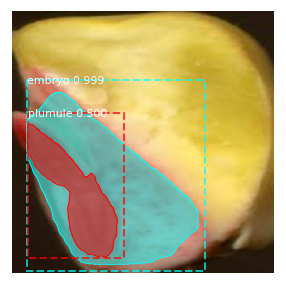

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


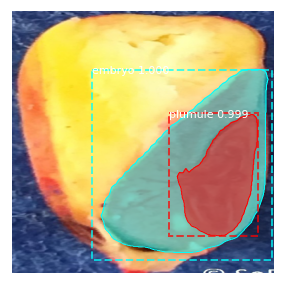

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  131.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


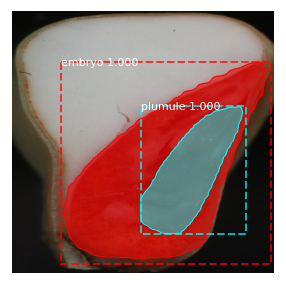

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  131.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


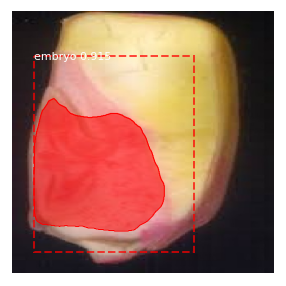

In [43]:
import skimage
#real_test_dir = ROOT_DIR+'/data/coco/test/'
real_test_dir ='/content/test/'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg','.JPG']:
        image_paths.append(os.path.join(real_test_dir, filename))
for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))